# K-Nearest Neighbor (KNN) - MONK

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold

import common code (utils)

In [2]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import monk_utils as utils
from common.monk_utils import MonkDataset

In [3]:
RANDOM_STATE = 42

### Data Preparation

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
# Ensure monk_utils is imported as utils

def run_monk_experiment(train_dataset, test_dataset, id_dataset):
    print(f"\n{'='*20} Processing MONK {id_dataset} {'='*20}")
    
    # 1. Load Data
    X_train_raw, y_train = utils.load_monk_dataset(train_dataset)
    X_test_raw, y_test = utils.load_monk_dataset(test_dataset)
    
    # 2. One-Hot Encoding
    encoder = utils.MonkEncoder()
    X_train = encoder.fit_transform(X_train_raw)
    X_test = encoder.transform(X_test_raw)
    
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    # 3. Rigorous Grid Search (CV)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # --- HYPERPARAMETERS ---
    k_values = [1, 3, 5, 7] # Keep K small for MONK!
    weights_options = ['uniform', 'distance']
    metrics = [1, 2] # 1 = Manhattan (CRITICAL), 2 = Euclidean
    
    best_score = -np.inf
    best_params = {}
    
    # Search Loop
    for p in metrics:
        for w in weights_options:
            for k in k_values:
                
                fold_accuracies = []
                
                for train_idx, val_idx in kf.split(X_train):
                    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
                    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
                    
                    # Pass 'p' to the classifier
                    knn = KNeighborsClassifier(n_neighbors=k, weights=w, p=p)
                    knn.fit(X_cv_train, y_cv_train)
                    
                    val_pred = knn.predict(X_cv_val)
                    acc = utils.calc_accuracy(y_cv_val, val_pred)
                    fold_accuracies.append(acc)
                
                avg_acc = np.mean(fold_accuracies)
                
                if avg_acc > best_score:
                    best_score = avg_acc
                    best_params = {'n_neighbors': k, 'weights': w, 'p': p}

    print(f"Best Params found: {best_params} (CV Acc: {best_score:.2%})")
    
    # 4. Final Training with Best Params
    final_model = KNeighborsClassifier(**best_params)
    final_model.fit(X_train, y_train)
    
    # 5. Plotting (Accuracy vs K) for the BEST metric/weight combo
    plot_k_values = range(1, 15)
    train_accs = []
    test_accs = []
    train_mses = []
    test_mses = []
    
    best_w = best_params['weights']
    best_p = best_params['p']
    
    for k in plot_k_values:
        # Use the best 'p' and 'weights' found, vary K
        model = KNeighborsClassifier(n_neighbors=k, weights=best_w, p=best_p)
        model.fit(X_train, y_train)
        
        tr_pred = model.predict(X_train)
        ts_pred = model.predict(X_test)
        
        train_accs.append(utils.calc_accuracy(y_train, tr_pred))
        test_accs.append(utils.calc_accuracy(y_test, ts_pred))
        train_mses.append(utils.calc_mse(y_train, tr_pred))
        test_mses.append(utils.calc_mse(y_test, ts_pred))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # MSE Plot
    ax1.plot(plot_k_values, train_mses, label='Train MSE', marker='o')
    ax1.plot(plot_k_values, test_mses, label='Test MSE', marker='x', linestyle='--')
    ax1.set_title(f'MONK {id_dataset}: MSE vs K (p={best_p}, {best_w})')
    ax1.set_xlabel('K (Neighbors)')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy Plot
    ax2.plot(plot_k_values, train_accs, label='Train Acc', marker='o')
    ax2.plot(plot_k_values, test_accs, label='Test Acc', marker='x', linestyle='--')
    ax2.set_title(f'MONK {id_dataset}: Accuracy vs K (p={best_p}, {best_w})')
    ax2.set_xlabel('K (Neighbors)')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()
    
    # 6. Final Report
    final_tr_pred = final_model.predict(X_train)
    final_ts_pred = final_model.predict(X_test)
    
    print(f"FINAL REPORT for MONK {id_dataset}")
    print(f"MSE (Train/Test):      {utils.calc_mse(y_train, final_tr_pred):.4f} / {utils.calc_mse(y_test, final_ts_pred):.4f}")
    print(f"Accuracy (Train/Test): {utils.calc_accuracy(y_train, final_tr_pred):.2%} / {utils.calc_accuracy(y_test, final_ts_pred):.2%}")


==================== Processing MONK 1 ====================
Train shape: (124, 17), Test shape: (432, 17)
Best Params found: {'n_neighbors': 5, 'weights': 'distance', 'p': 1} (CV Acc: 75.03%)


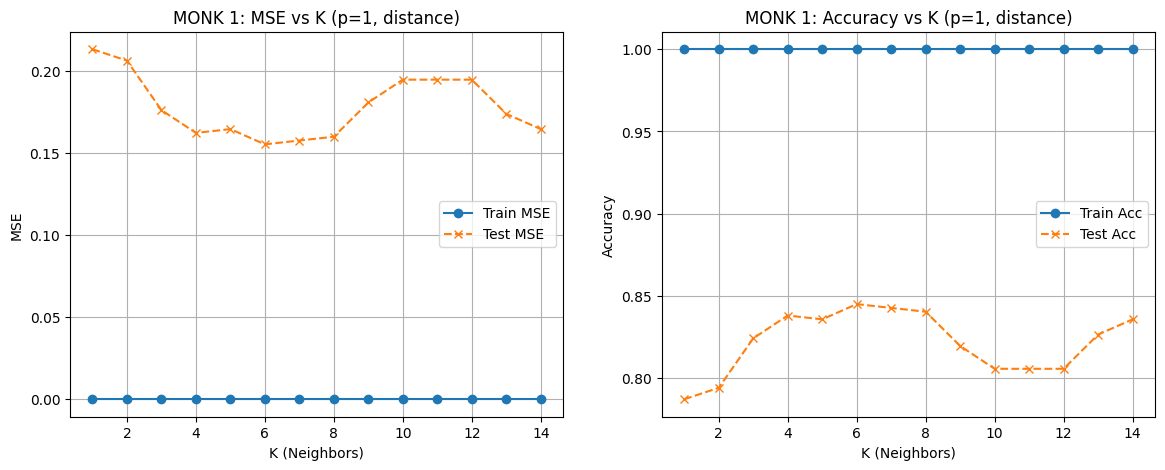

FINAL REPORT for MONK 1
MSE (Train/Test):      0.0000 / 0.1644
Accuracy (Train/Test): 100.00% / 83.56%

==================== Processing MONK 2 ====================
Train shape: (169, 17), Test shape: (432, 17)
Best Params found: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1} (CV Acc: 62.75%)


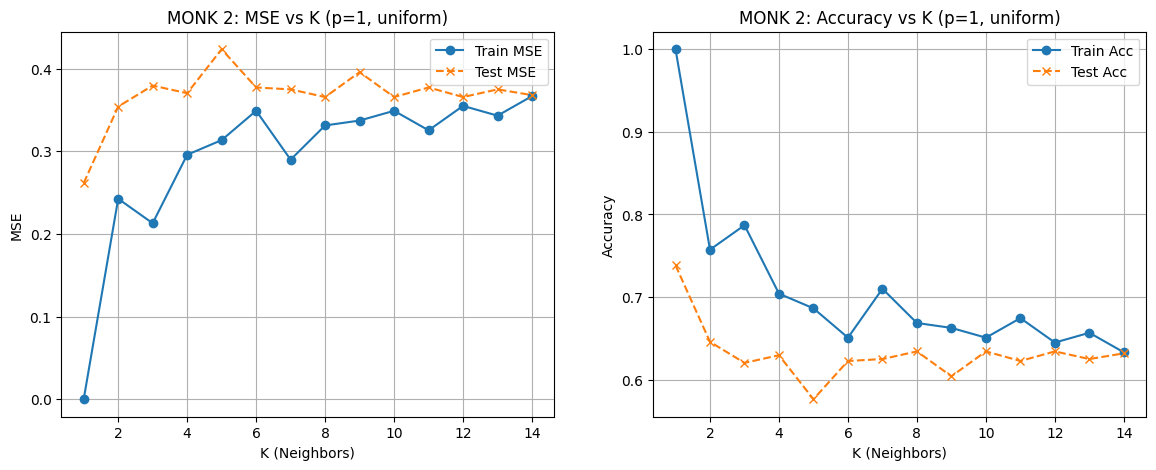

FINAL REPORT for MONK 2
MSE (Train/Test):      0.0000 / 0.2616
Accuracy (Train/Test): 100.00% / 73.84%

==================== Processing MONK 3 ====================
Train shape: (122, 17), Test shape: (432, 17)
Best Params found: {'n_neighbors': 7, 'weights': 'distance', 'p': 1} (CV Acc: 86.07%)


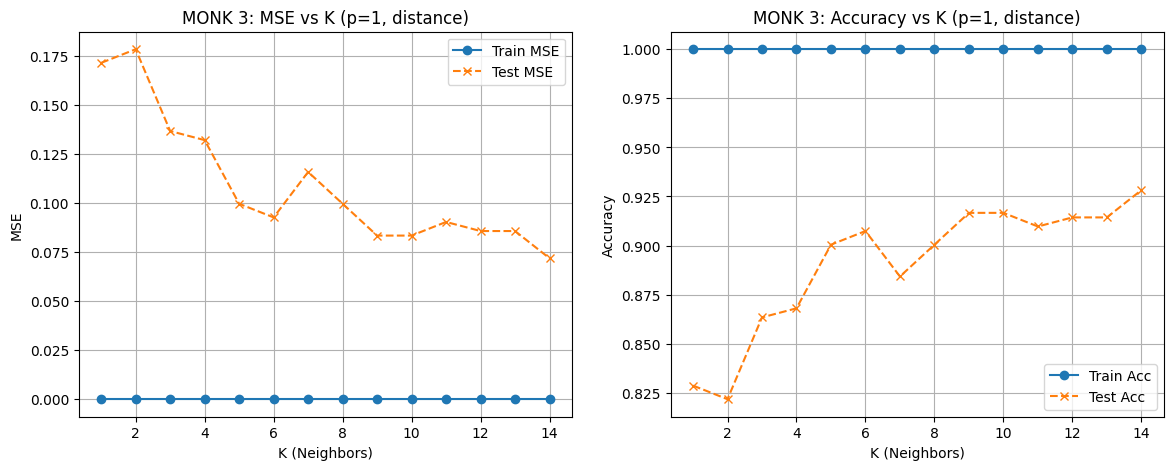

FINAL REPORT for MONK 3
MSE (Train/Test):      0.0000 / 0.1157
Accuracy (Train/Test): 100.00% / 88.43%


In [5]:
# --- MAIN EXECUTION ---
# Ensure you have the dataset files in a 'datasets/' folder relative to this notebook!
# You can download them from the UCI repo or Moodle.

run_monk_experiment(train_dataset=MonkDataset.MONK1_TRAIN, test_dataset=MonkDataset.MONK1_TEST, id_dataset=1)
run_monk_experiment(train_dataset=MonkDataset.MONK2_TRAIN, test_dataset=MonkDataset.MONK2_TEST, id_dataset=2)
run_monk_experiment(train_dataset=MonkDataset.MONK3_TRAIN, test_dataset=MonkDataset.MONK3_TEST, id_dataset=3)